# **PyTorch Time Series Forecasting** 

<font size=4>[[YouTube]](https://youtu.be/AvKSPZ7oyVg)<br>
<font size=4>with Patrick Loeber<br>
	
<font size=4>Predicting a sin wave, which can be used on any other time series data


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating the data**

In [2]:
num_samples = 100
len_sample = 1000
width_wave = 20

# Creating the wave data
inputs = np.empty((num_samples, len_sample), np.float32)

# Shift the values for each sample
inputs[:] = (np.array(range(len_sample)) + np\
			 .random.randint(-4 * width_wave, 4 * width_wave, 
							 num_samples).reshape(num_samples, 1))
			 
# Creating corresponding sin values
targets = np.sin(inputs / 1.0 / width_wave).astype(np.float32)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Plotting the created input data**

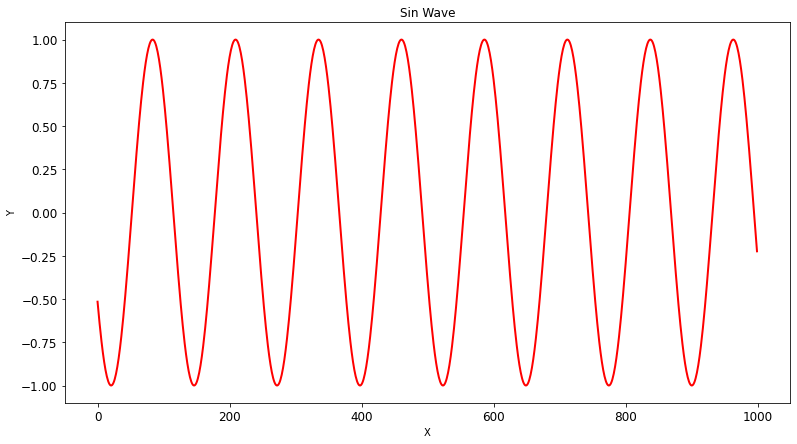

In [3]:
plt.figure(figsize = (13, 7))
plt.title("Sin Wave")
plt.xlabel("X"); plt.ylabel("Y")
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.plot(np.arange(inputs.shape[1]), targets[0, :], "r", linewidth = 2.0)
plt.show()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating LSTM Model Architecture**

In [4]:
class LSTM_Predictor(nn.Module):
	def __init__(self, num_hidden=51):
		super(LSTM_Predictor, self).__init__()
		self.num_hidden = num_hidden
		
		# Creating layers with two LSTM layers and 1 Linear Layer
		# LSTMCell is slightly different from LSTM, flexibility?
		
		self.lstm_01 = nn.LSTMCell(1, self.num_hidden)
		self.lstm_02 = nn.LSTMCell(self.num_hidden, self.num_hidden)
		self.linear = nn.Linear(self.num_hidden, 1)
	
	# Future is the number of values desired to predict
	# 0 for training
	
	def forward(self, inputs, future = 0):
		outputs = []
		num_samples = inputs.size(0)
		
		hidden_initial = torch.zeros(num_samples, 
									 self.num_hidden, 
									 dtype = torch.float32)
		
		cell_initial = torch.zeros(num_samples, 
									 self.num_hidden, 
									 dtype = torch.float32)
		
		hidden_state2 = torch.zeros(num_samples, 
									 self.num_hidden, 
									 dtype = torch.float32)
		
		cell_state2 = torch.zeros(num_samples, 
									 self.num_hidden, 
									 dtype = torch.float32)
		
		# splitting tensor into sections, views of original, to be utilized
		# taking one by one
		
		for input_t in inputs.split(1, dim=1):
			hidden_initial, cell_initial = self.lstm_01(input_t, 
														(hidden_initial, cell_initial))
			hidden_state2, cell_state2 = self.lstm_02(hidden_initial, 
													 (hidden_state2, cell_state2))
			output = self.linear(hidden_state2)
			outputs.append(output)
			
		# if future > 0, this will also create a predictions
		
		for item in range(future):
			hidden_initial, cell_initial = self.lstm_01(output, 
														(hidden_initial, cell_initial))
			hidden_state2, cell_state2 = self.lstm_02(hidden_initial, 
													 (hidden_state2, cell_state2))
			output = self.linear(hidden_state2)
			outputs.append(output)
			
		outputs = torch.cat(outputs, dim=1)
		
		return outputs

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating Training and Testing Samples**
* Targets shape = (100, 1000)
* train_inputs = (97, 100)
* train_targets = (97, 100)
* test_inputs = (3, 999)
* test_targets = (3, 999)

In [5]:
# inputs come from target values, taking the previous position
train_inputs = torch.from_numpy(targets[3:, : -1])

# the following will then predict the next position
train_targets = torch.from_numpy(targets[3:, 1:])

# inputs come from target values, taking the previous position
test_inputs = torch.from_numpy(targets[:3, : -1])

# the following will then predict the next position
test_targets = torch.from_numpy(targets[:3, 1:])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Defining Model**
* Limited-Memory BFGS - Algorithm that works different from Adam
* Works on entire data
* Needs a function as an imput, which is the closure function in the training loop

In [6]:
model = LSTM_Predictor()
loss_function = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr = 0.08)
num_steps = 10

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Training Loop**

In [7]:
def train_model(model, 
				num_steps, 
				optimizer, 
				loss_function,
				train_inputs, 
				train_targets, 
				test_inputs, 
				test_targets,
				num_samples, 
				targets):
	
	for step in range(num_steps):
		print("Step: ", step)
		
		def closure():
			optimizer.zero_grad()
			out = model(train_inputs)
			loss = loss_function(out, train_targets)
			print("Training Loss: ", loss.item())
			loss.backward()
			return loss
	
		optimizer.step(closure)
		
		with torch.no_grad():
			future = 1000
			predictions = model(test_inputs, future = future)
			
			# starting at the beginning and excluding the last future values
			loss = loss_function(predictions[:, :-future], test_targets)
			print("Test Loss: ", loss.item())
			
			prediction = predictions.detach().numpy()
			
		plt.figure(figsize = (13, 7))
		plt.title(f"Step {step + 1}")
		plt.xlabel("X"); plt.ylabel("Y")
		plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
		plt.plot(np.arange(inputs.shape[1]), targets[0, :], "r", linewidth = 2.0)
		plt.show()
		
		num_samples = train_inputs.shape[1]
		
		def draw(prediction_item, color):
			plt.plot(np.arange(num_samples), 
					prediction_item[:num_samples], 
					color, linewidth = 2.0)
			plt.plot(np.arange(num_samples, num_samples + future), 
					prediction_item[num_samples:], 
					color, linestyle=":", linewidth = 2.0)
			
		draw(prediction[0], 'red')
		draw(prediction[1], 'blue')
		draw(prediction[2], 'green')
		
		# %d = current step
		plt.savefig('predictions' + f'{step}' + '.pdf')
		plt.close()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Trying it all out**

Step:  0
Training Loss:  0.5071024298667908
Training Loss:  0.5065000057220459
Training Loss:  0.502899169921875
Training Loss:  0.49697253108024597
Training Loss:  0.4873402714729309
Training Loss:  0.4712724983692169
Training Loss:  0.4441855549812317
Training Loss:  0.4039461612701416
Training Loss:  0.36297154426574707
Training Loss:  0.3278220295906067
Training Loss:  0.2915146052837372
Training Loss:  0.2547015845775604
Training Loss:  0.22469305992126465
Training Loss:  0.19905708730220795
Training Loss:  0.17297379672527313
Training Loss:  0.14557935297489166
Training Loss:  0.11942685395479202
Training Loss:  0.09735578298568726
Training Loss:  0.08006604015827179
Training Loss:  0.06682467460632324
Test Loss:  0.05617847666144371


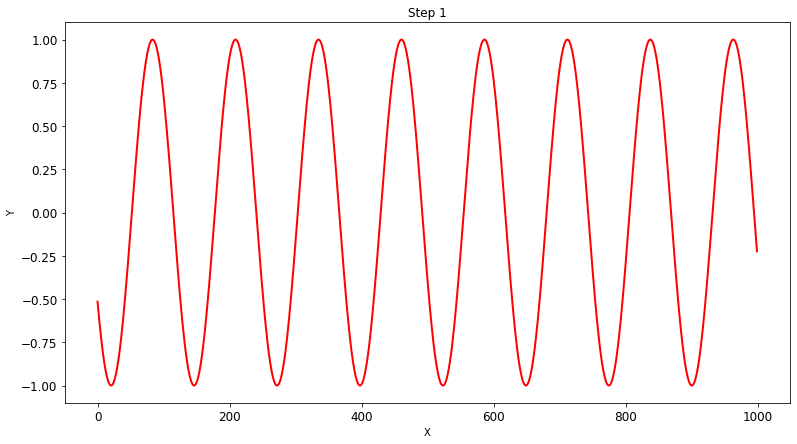

Step:  1
Training Loss:  0.05667776241898537
Training Loss:  0.0488324835896492
Training Loss:  0.0426965169608593
Training Loss:  0.037842024117708206
Training Loss:  0.033961210399866104
Training Loss:  0.030830441042780876
Training Loss:  0.02828465960919857
Training Loss:  0.026200158521533012
Training Loss:  0.02448268234729767
Training Loss:  0.023059476166963577
Training Loss:  0.021873708814382553
Training Loss:  0.020880529657006264
Training Loss:  0.02004423178732395
Training Loss:  0.019336169585585594
Training Loss:  0.01873321644961834
Training Loss:  0.018216615542769432
Training Loss:  0.017771026119589806
Training Loss:  0.017383895814418793
Training Loss:  0.017044873908162117
Training Loss:  0.016745390370488167
Test Loss:  0.01566590741276741


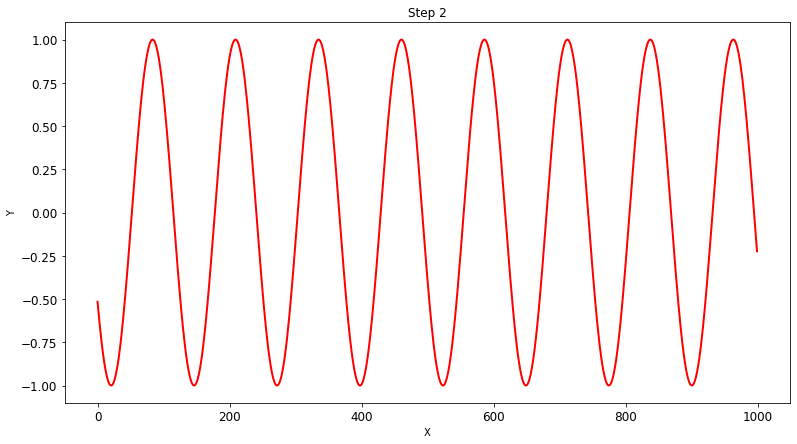

Step:  2
Training Loss:  0.01647830381989479
Training Loss:  0.01623765006661415
Training Loss:  0.01601838320493698
Training Loss:  0.015816206112504005
Training Loss:  0.015627430751919746
Training Loss:  0.015448831021785736
Training Loss:  0.015277541242539883
Training Loss:  0.01511097140610218
Training Loss:  0.01494672056287527
Training Loss:  0.014782514423131943
Training Loss:  0.014616124331951141
Training Loss:  0.014445331878960133
Training Loss:  0.014267860911786556
Training Loss:  0.014081313274800777
Training Loss:  0.013883127830922604
Training Loss:  0.013670498505234718
Training Loss:  0.013440299779176712
Training Loss:  0.01318899542093277
Training Loss:  0.012912486679852009
Training Loss:  0.012605908326804638
Test Loss:  0.011478468775749207


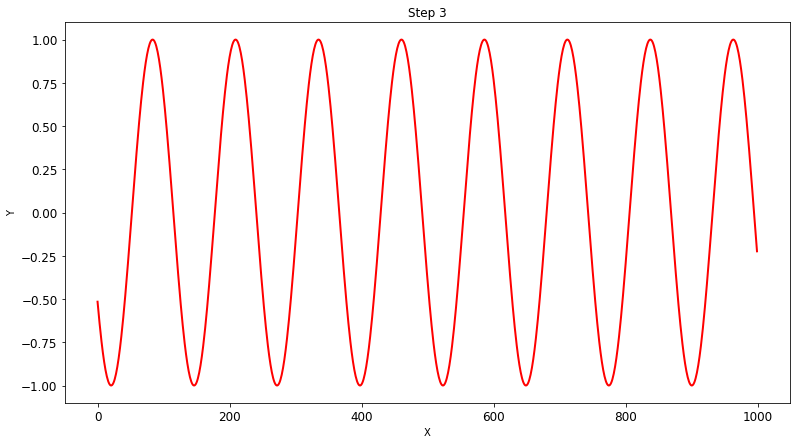

Step:  3
Training Loss:  0.012263298965990543
Training Loss:  0.011877050623297691
Training Loss:  0.011436909437179565
Training Loss:  0.010927998460829258
Training Loss:  0.010326412506401539
Training Loss:  0.009587893262505531
Training Loss:  0.00861205905675888
Training Loss:  0.007130887359380722
Training Loss:  0.004972562193870544
Training Loss:  0.003676916938275099
Training Loss:  0.003140190150588751
Training Loss:  0.0027989624068140984
Training Loss:  0.0025360279250890017
Training Loss:  0.002327332738786936
Training Loss:  0.002159216906875372
Training Loss:  0.0020216393750160933
Training Loss:  0.0019074567826464772
Training Loss:  0.0018115732818841934
Training Loss:  0.0017302632331848145
Training Loss:  0.0016607296420261264
Test Loss:  0.0012678852071985602


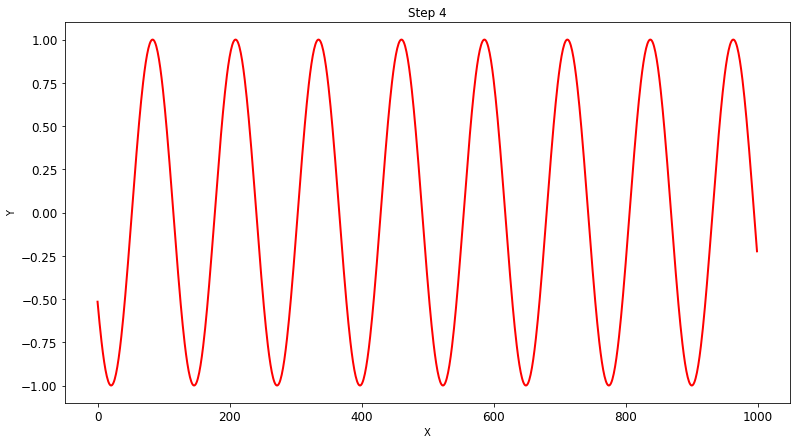

Step:  4
Training Loss:  0.0016008318634703755
Training Loss:  0.0015488999197259545
Training Loss:  0.0015036067925393581
Training Loss:  0.0014638855354860425
Training Loss:  0.0014288583770394325
Training Loss:  0.0013977931812405586
Training Loss:  0.001370068988762796
Training Loss:  0.0013451448176056147
Training Loss:  0.0013225493021309376
Training Loss:  0.0013018600875511765
Training Loss:  0.0012827011523768306
Training Loss:  0.001264735939912498
Training Loss:  0.001247668405994773
Training Loss:  0.001231223694048822
Training Loss:  0.0012151955161243677
Training Loss:  0.0011992307845503092
Training Loss:  0.0011832526652142406
Training Loss:  0.0011665415950119495
Training Loss:  0.001152183162048459
Training Loss:  0.0011377829359844327
Test Loss:  0.0008509771432727575


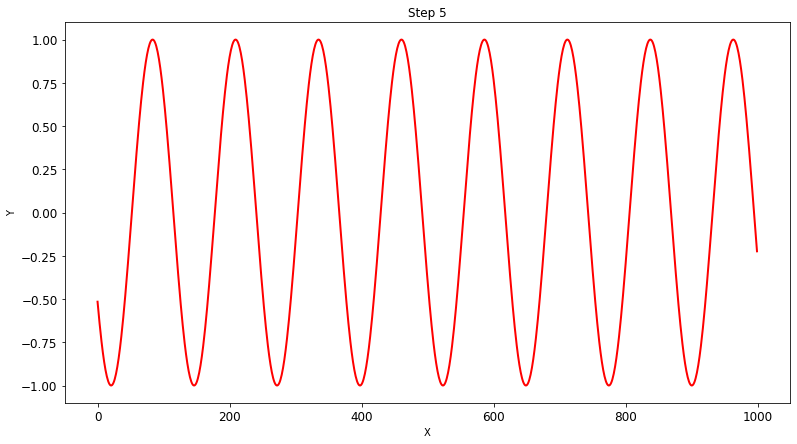

Step:  5
Training Loss:  0.001122130430303514
Training Loss:  0.0011050369357690215
Training Loss:  0.0010859573958441615
Training Loss:  0.0010649748146533966
Training Loss:  0.0010419408790767193
Training Loss:  0.001018619048409164
Training Loss:  0.0009924109326675534
Training Loss:  0.0009599246550351381
Training Loss:  0.0009170908015221357
Training Loss:  0.0008643291657790542
Training Loss:  0.0008059229585342109
Training Loss:  0.0007458736654371023
Training Loss:  0.0006893276004120708
Training Loss:  0.0006399158155545592
Training Loss:  0.0005938893300481141
Training Loss:  0.0005531203933060169
Training Loss:  0.0005200183368287981
Training Loss:  0.0004923477536067367
Training Loss:  0.00046771217603236437
Training Loss:  0.0004452774301171303
Test Loss:  0.00024068914353847504


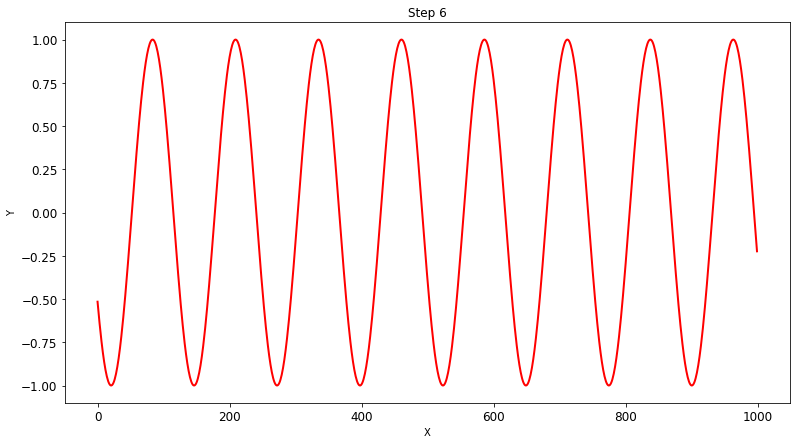

Step:  6
Training Loss:  0.00042551651131361723
Training Loss:  0.00040824999450705945
Training Loss:  0.00039281658246181905
Training Loss:  0.0003795067605096847
Training Loss:  0.0003673061728477478
Training Loss:  0.00035678790300153196
Training Loss:  0.00034717252128757536
Training Loss:  0.00033878179965540767
Training Loss:  0.0003311291802674532
Training Loss:  0.0003244036342948675
Training Loss:  0.0003182969521731138
Training Loss:  0.0003129045362584293
Training Loss:  0.00030802286346443
Training Loss:  0.000303687178529799
Training Loss:  0.0002997592673636973
Training Loss:  0.00029624413582496345
Training Loss:  0.0002930425980594009
Training Loss:  0.0002901490079239011
Training Loss:  0.00028748559998348355
Training Loss:  0.00028504806687124074
Test Loss:  0.00013879411562811583


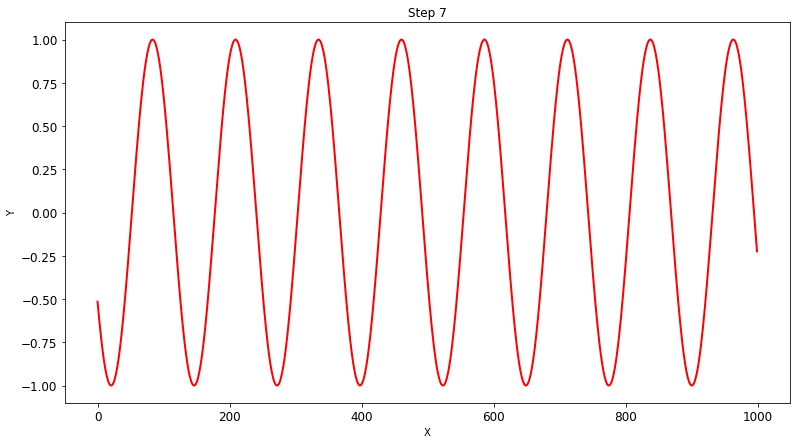

Step:  7
Training Loss:  0.0002827692951541394
Training Loss:  0.00028065216611139476
Training Loss:  0.0002786357654258609
Training Loss:  0.00027672952273860574
Training Loss:  0.0002748778788372874
Training Loss:  0.00027309361030347645
Training Loss:  0.0002713260182645172
Training Loss:  0.0002695891016628593
Training Loss:  0.00026783495559357107
Training Loss:  0.0002660775789991021
Training Loss:  0.00026426854310557246
Training Loss:  0.00026241946034133434
Training Loss:  0.0002604711626190692
Training Loss:  0.000258463725913316
Training Loss:  0.00025622182874940336
Training Loss:  0.0002540433488320559
Training Loss:  0.00025166160776279867
Training Loss:  0.00024891734938137233
Training Loss:  0.0002460474497638643
Training Loss:  0.0002428837469778955
Test Loss:  0.00012169327237643301


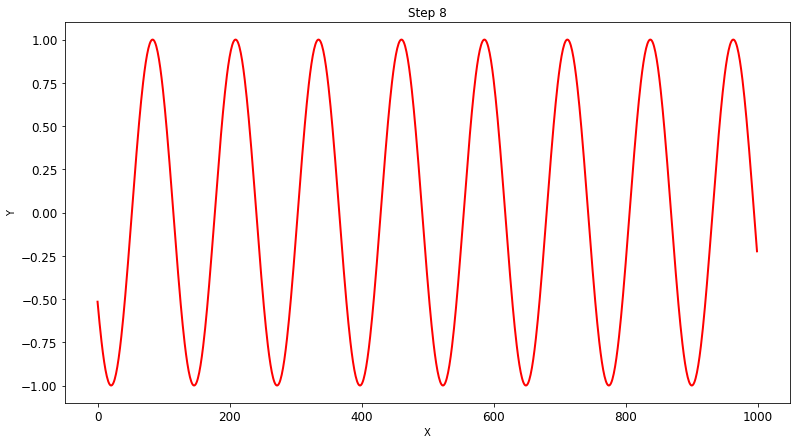

Step:  8
Training Loss:  0.00023947488807607442
Training Loss:  0.00023566979507450014
Training Loss:  0.00023159352713264525
Training Loss:  0.0002270376862725243
Training Loss:  0.0002222214825451374
Training Loss:  0.00021689040295314044
Training Loss:  0.00021146764629520476
Training Loss:  0.00020565016893669963
Training Loss:  0.00019993085879832506
Training Loss:  0.00019402398902457207
Training Loss:  0.00018843535508494824
Training Loss:  0.00018293570610694587
Training Loss:  0.00017784563533496112
Training Loss:  0.00017305935034528375
Training Loss:  0.0001686696632532403
Training Loss:  0.00016468633839394897
Training Loss:  0.00016101209621410817
Training Loss:  0.00015768293815199286
Training Loss:  0.00015454608364962041
Training Loss:  0.0001516618358436972
Test Loss:  8.165507460944355e-05


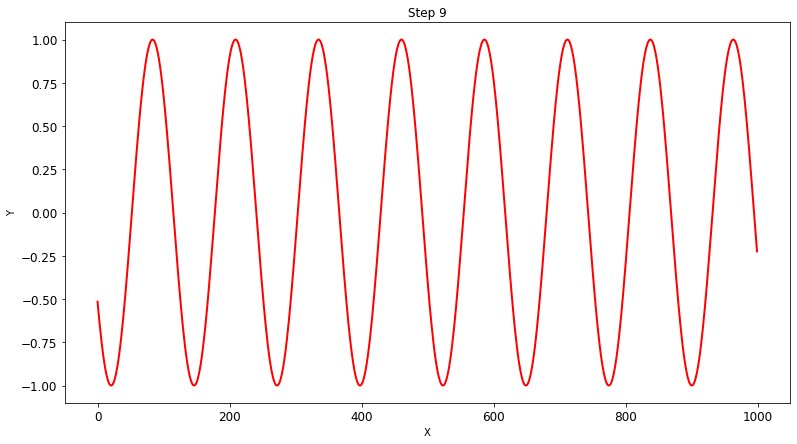

Step:  9
Training Loss:  0.00014893824118189514
Training Loss:  0.00014647004718426615
Training Loss:  0.00014418928185477853
Training Loss:  0.00014223808830138296
Training Loss:  0.0001405116927344352
Training Loss:  0.0001389161334373057
Training Loss:  0.00013748292985837907
Training Loss:  0.000136158152599819
Training Loss:  0.0001349654485238716
Training Loss:  0.00013386091450229287
Training Loss:  0.00013286348257679492
Training Loss:  0.0001319387520197779
Training Loss:  0.00013110069266986102
Training Loss:  0.00013032180140726268
Training Loss:  0.00012961217726115137
Training Loss:  0.00012894898827653378
Training Loss:  0.0001283392048208043
Training Loss:  0.0001277629635296762
Training Loss:  0.00012722451356239617
Training Loss:  0.00012670647993218154
Test Loss:  8.290564437629655e-05


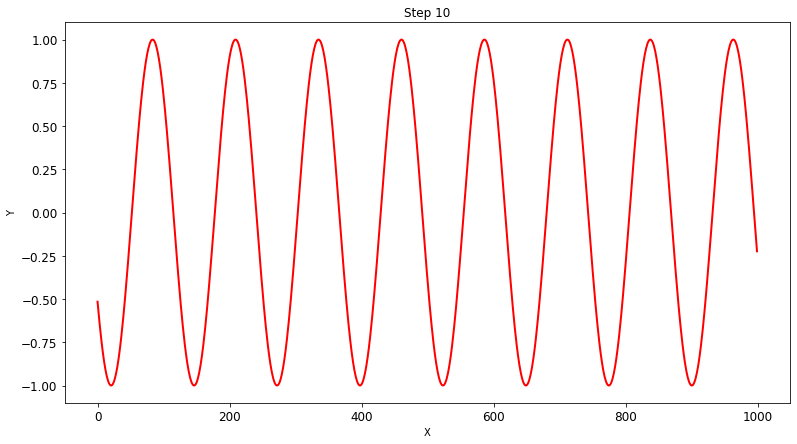

In [8]:
train_model(model = model, 
			num_steps = num_steps, 
			optimizer = optimizer, 
			loss_function = loss_function,
			train_inputs = train_inputs, 
			train_targets = train_targets, 
			test_inputs = test_inputs, 
			test_targets = test_targets,
			num_samples = num_samples, 
			targets = targets)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Text**

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Text**